Cell-1

In [ ]:
!pip install --quiet opencv-python-headless tensorflow scikit-learn matplotlib

Cell-2

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def preprocess_image(img, target_size=(224, 224)):
    img = cv2.resize(img, target_size)

    # LAB + CLAHE contrast enhancement
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.8, tileGridSize=(8,8))
    l_clahe = clahe.apply(l)
    lab_clahe = cv2.merge((l_clahe, a, b))
    enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)

    # Denoising
    denoised = cv2.bilateralFilter(enhanced, d=9, sigmaColor=75, sigmaSpace=75)

    # Sharpening
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(denoised, -1, kernel)

    return sharpened.astype(np.float32) / 255.0

Cell-3

In [ ]:
def load_dataset(data_dir="/content/dataset", img_size=(224, 224)):
    images = []
    labels = []
    class_names = ['crack', 'corrosion', 'normal']
    class_to_idx = {name: idx for idx, name in enumerate(class_names)}

    for class_name in class_names:
        folder = os.path.join(data_dir, class_name)
        print(f"Loading {class_name}...")
        if not os.path.exists(folder):
            print(f"  → Folder not found: {folder}")
            continue

        for filename in os.listdir(folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                path = os.path.join(folder, filename)
                img = cv2.imread(path)
                if img is not None:
                    processed = preprocess_image(img, img_size)
                    images.append(processed)
                    labels.append(class_to_idx[class_name])
                else:
                    print(f"  Failed to load: {filename}")

    print(f"\nLoaded total: {len(images)} images")
    if len(images) > 0:
        print("Class distribution:", dict(zip(class_names, np.bincount(labels))))

    return np.array(images), np.array(labels)

Cell-4

In [ ]:
def create_model(input_shape=(224, 224, 3)):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(256, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()
    return model

Cell-5

In [ ]:
from google.colab import files
print("Upload your dataset.zip file")
uploaded = files.upload()

Upload your dataset.zip file


Saving dataset.zip to dataset.zip


Cell-6

In [ ]:
!unzip -q dataset.zip -d /content/
print("Dataset unzipped to /content/dataset")
!ls /content/dataset

Dataset unzipped to /content/dataset
corrosion  crack  normal


Cell-7

Loading crack...
Loading corrosion...
  Failed to load: wreck-passenger-ship-salem-express-bottom-red-sea-egypt-wreck-passenger-ship-salem-express-covered-coral-134901344_jpg.rf.b45280a4f1bac74fc869bdaf606af535.jpg
Loading normal...

Loaded total: 354 images
Class distribution: {'crack': np.int64(121), 'corrosion': np.int64(113), 'normal': np.int64(120)}

Training samples: 283
Validation samples: 71


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 523,459 (2.00 MB)

 Trainable params: 522,499 (1.99 MB)

 Non-trainable params: 960 (3.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 610ms/step - accuracy: 0.7320 - loss: 0.5625 - val_accuracy: 0.5211 - val_loss: 0.9349
Epoch 2/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7500 - loss: 0.9850 - val_accuracy: 0.4085 - val_loss: 0.9427
Epoch 3/40


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 233ms/step - accuracy: 0.8762 - loss: 0.3397 - val_accuracy: 0.3803 - val_loss: 1.0766
Epoch 4/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0479 - val_accuracy: 0.3380 - val_loss: 1.1225
Epoch 5/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9302 - loss: 0.1861 - val_accuracy: 0.3380 - val_loss: 2.5617
Epoch 6/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9375 - loss: 0.2761 - val_accuracy: 0.3380 - val_loss: 2.5524
Epoch 7/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - accuracy: 0.9115 - loss: 0.2700 - val_accuracy: 0.3380 - val_loss: 1.3027
Epoch 8/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0711 - val_accuracy: 0.3380 - val_loss: 1.2933
Epoch 9/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - accuracy: 0.8924 - loss: 0.3487 - val_accuracy: 0.3380 - val_loss: 4.8305
Epoch 10/40
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0730 - val_accuracy: 0.3380 - val_loss: 4


Model saved: /content/pipe_defect_model.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

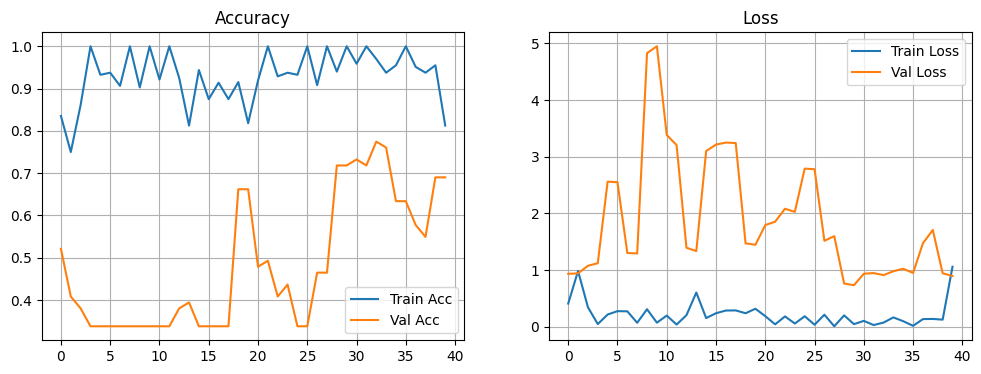

In [ ]:
# Load data
X, y = load_dataset(data_dir="/content/dataset")

if len(X) == 0:
    print("ERROR: No images loaded. Check folder structure and files.")
else:
    # Split
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.20, random_state=42, stratify=y
    )

    print(f"\nTraining samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

    # Augmentation
    datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create & train
    model = create_model()

    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=16),
        validation_data=(X_val, y_val),
        epochs=40,
        steps_per_epoch=len(X_train) // 16,
        verbose=1
    )

    # Save
    model.save("/content/pipe_defect_model.h5")
    print("\nModel saved: /content/pipe_defect_model.h5")

    # Download model
    from google.colab import files
    files.download("/content/pipe_defect_model.h5")

    # Plot
    plt.figure(figsize=(12, 4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

Cell-8

Upload a pipe image to classify...


Saving 054_agua_turbia_gris_jpg.rf.50e7fca413bd0153cf7fce1618857c2b.jpg to 054_agua_turbia_gris_jpg.rf.50e7fca413bd0153cf7fce1618857c2b.jpg

Processing: 054_agua_turbia_gris_jpg.rf.50e7fca413bd0153cf7fce1618857c2b.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step

PREDICTION: CRACK
Confidence: 99.67%

All probabilities:
  crack      : 99.67%
  corrosion  : 0.33%
  normal     : 0.00%


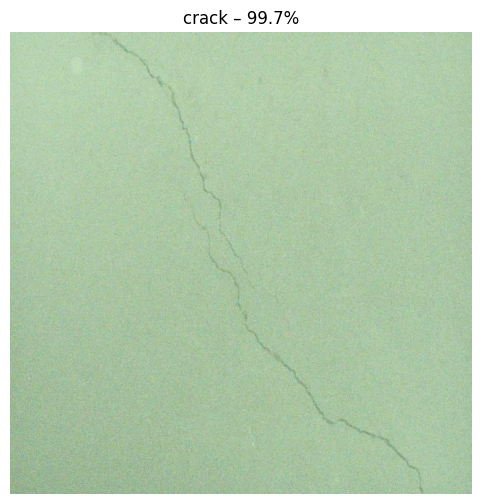

In [ ]:
from google.colab import files
import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Load model
model = tf.keras.models.load_model("/content/pipe_defect_model.h5")

# Same preprocessing function (already defined above)
# If you restarted runtime, make sure to run Cell 2 first

print("Upload a pipe image to classify...")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    print(f"\nProcessing: {filename}")

    img = cv2.imread(filename)
    if img is None:
        print("Error reading image.")
    else:
        processed = preprocess_image(img)
        pred = model.predict(np.expand_dims(processed, axis=0))[0]

        classes = ['crack', 'corrosion', 'normal']
        predicted_class = classes[np.argmax(pred)]
        confidence = pred.max() * 100

        print("\n" + "="*60)
        print(f"PREDICTION: {predicted_class.upper()}")
        print(f"Confidence: {confidence:.2f}%")
        print("="*60)

        print("\nAll probabilities:")
        for c, p in zip(classes, pred):
            print(f"  {c:10} : {p*100:.2f}%")

        # Show image
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"{predicted_class} – {confidence:.1f}%")
        plt.axis('off')
        plt.show()